In [1]:
#Importing required libraries to implement double DQN
import gym
import torch
from collections import deque
import random
import copy
from torch.autograd import Variable

env = gym.envs.make("CartPole-v1")


In [2]:

#Defining the double DQN class which contains the improvement of having two neural networks
#one for the prediction the other for the target 
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_action)
                )

        #the network for the target with the same structure as the original
        self.model_target = copy.deepcopy(self.model)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        #function to update the weights each time 

        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, s):
        #prediction function that takes the state as an input and update the Q value
        with torch.no_grad():
            return self.model(torch.Tensor(s))

    def target_predict(self, s):
        #Computing the neural network of the target to learn how to predict the targeted Qvalue
        with torch.no_grad():
            return self.model_target(torch.Tensor(s))

    def replay(self, memory, replay_size, gamma):
        #Implementing experience replay 
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)

            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state).detach()

                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                td_targets.append(q_values)

            self.update(states, td_targets)

    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())




In [3]:
#implementing the gready policy that would increase with the time the level of exploitation and decreases exploration
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    return policy_function

In [12]:
steps=[]


def q_learning(env, estimator, n_episode, replay_size, target_update=10, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    #defining the classic Q learning function with a littke modification as it includes lines regarding the target 
  # a loop that would take care of the frequency of the target update
    for episode in range(n_episode):
        
        if episode % target_update == 0:
            estimator.copy_target()

        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
        state = env.reset()
        is_done = False
        
        
        stepsl=0
        while not is_done:

            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)

            total_reward_episode[episode] += reward

            memory.append((state, action, next_state, reward, is_done))
            stepsl+=1
            steps.append(stepsl)
            if is_done:
                break

            estimator.replay(memory, replay_size, gamma)

            state = next_state

        epsilon = max(epsilon * epsilon_decay, 0.01)
        



In [7]:
#Setting some hyper paramets
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_episode = 600
last_episode = 200

In [16]:
#Grid search to tune hyper paramers and find the best value that would boost the preformaance 

n_hidden_options = [30,35, 40]
lr_options = [0.001, 0.003, 0.005]
replay_size_options = [25,30, 35]
target_update_options = [35,40, 45]


filename = 'tuning.pickle'
for n_hidden in n_hidden_options:
    for lr in lr_options:
        for replay_size in replay_size_options:
            for target_update in target_update_options:
                env.seed(1)
                random.seed(1)
                torch.manual_seed(1)

                dqn = DQN(n_state, n_action, n_hidden, lr)
                memory = deque(maxlen=10000)
                total_reward_episode = [0] * n_episode

                q_learning(env, dqn, n_episode, replay_size, target_update, gamma=.9, epsilon=1)
                
                print(n_hidden, lr, replay_size, target_update, sum(total_reward_episode[-last_episode:])/last_episode)
                visual=n_hidden, lr, replay_size, target_update, sum(total_reward_episode[-last_episode:])/last_episode
                pickle.dump(visual, open(filename, 'wb'))

30 0.001 25 35 136.705
30 0.001 25 40 229.52
30 0.001 25 45 193.145
30 0.001 30 35 261.575
30 0.001 30 40 206.675
30 0.001 30 45 231.13
30 0.001 35 35 260.215
30 0.001 35 40 198.525
30 0.001 35 45 118.235
30 0.003 25 35 174.31
30 0.003 25 40 250.99
30 0.003 25 45 136.865
30 0.003 30 35 184.465
30 0.003 30 40 140.715
30 0.003 30 45 172.33
30 0.003 35 35 157.82
30 0.003 35 40 102.28
30 0.003 35 45 134.295
30 0.005 25 35 83.665
30 0.005 25 40 115.245
30 0.005 25 45 114.04
30 0.005 30 35 177.58
30 0.005 30 40 109.865
30 0.005 30 45 237.71
30 0.005 35 35 140.87
30 0.005 35 40 137.03
30 0.005 35 45 198.445
35 0.001 25 35 186.305
35 0.001 25 40 111.085
35 0.001 25 45 146.19
35 0.001 30 35 166.66
35 0.001 30 40 280.815
35 0.001 30 45 224.59
35 0.001 35 35 156.315
35 0.001 35 40 193.32
35 0.001 35 45 226.685
35 0.003 25 35 148.57
35 0.003 25 40 142.985
35 0.003 25 45 151.655


KeyboardInterrupt: ignored

In [15]:
#After finding the best values in the grid search this is the part where it trains one set of the defined number of episods

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 30
lr = 0.003
target_update=35
dqn = DQN(n_state, n_action, n_hidden, lr)
memory = deque(maxlen=10000)
n_episode = 2000
replay_size = 25
total_reward_episode = [0] * n_episode

q_learning(env, dqn, n_episode, replay_size, target_update, gamma=.9, epsilon=1)




KeyboardInterrupt: ignored

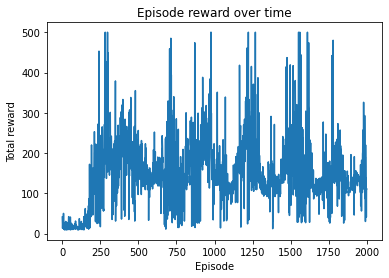

In [71]:

import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()
